In [1]:
import numpy as np
import gym
from hiive.mdptoolbox import example, mdp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time

#### Reference code: https://github.com/adodd202/GT-ML-Assignment4/blob/main/Frozen%20Lake%20Analysis.ipynb 
#### https://medium.com/@m.alzantot/deep-reinforcement-learning-demysitifed-episode-2-policy-iteration-value-iteration-and-q-978f9e89ddaa#:~:text=Value%20iteration%20computes%20the%20optimal,converge%20to%20the%20optimal%20values.

In [2]:
# credit https://github.com/wesley-smith/CS7641-assignment-4/blob/f3d86e37504dda563f65b3267610a30f09d01c77/helpers.py
# credit https://github.com/luclement/ml-assignment4/blob/master/frozen_lake.ipynb
TERM_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63]}
cmap = 'cool'
def visualize_env(env, name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)
    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)
    # fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()
def visualize_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(12,12))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [3]:
# Unpacked from gym.unwrapped.P is a list of states. Each state has a dictionary [0,1,2,3]. Each dictionary
# contains a 4 part tuple [probability(?),new_state,reward,finished]
def getRewardProb(env, sz):
    sz = int(sz**2)
    r = np.zeros((4,sz,sz))
    p = np.zeros((4,sz,sz))
    envP = env.unwrapped.P
    for state in envP:
        for action in envP[state]:
            transitions = envP[state][action]
            for t_idx in range((len(transitions))):
                new_state = transitions[t_idx][1]
                trans_prob = transitions[t_idx][0]
                reward = transitions[t_idx][2]
                p[action][state][new_state] += trans_prob
                r[action][state][new_state] += reward
            p[action,state,:] /= np.sum(p[action,state,:])
    return r, p

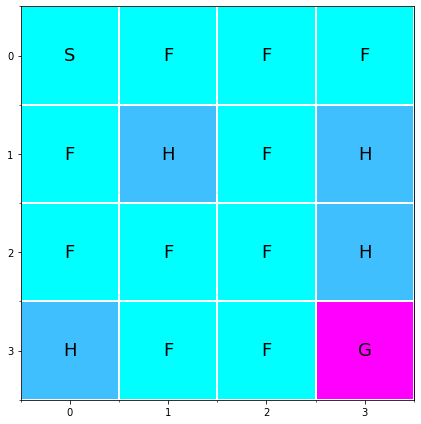

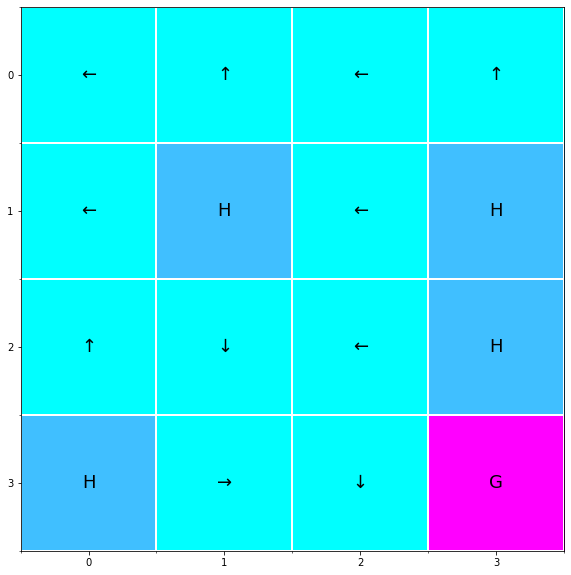

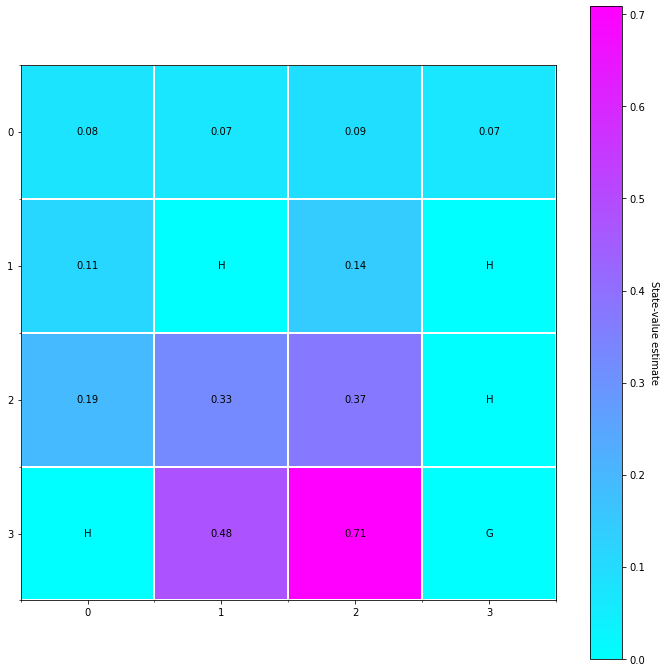

(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)
(0.07546183946330849, 0.06879696601381892, 0.09248715742956995, 0.0669831496284454, 0.11277551631678646, 0.0, 0.14463450542992798, 0.0, 0.1928271485205209, 0.3253030678496024, 0.3714331274786638, 0.0, 0.0, 0.47647119099942736, 0.708522413055065, 0.0)


In [4]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1")
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.96, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

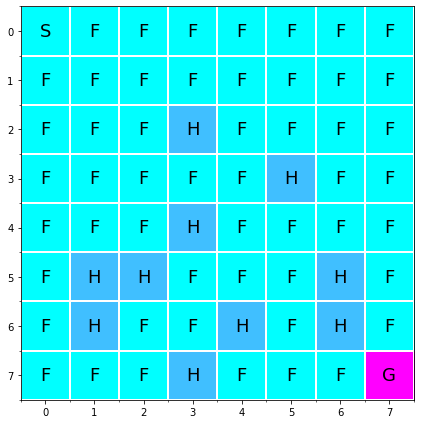

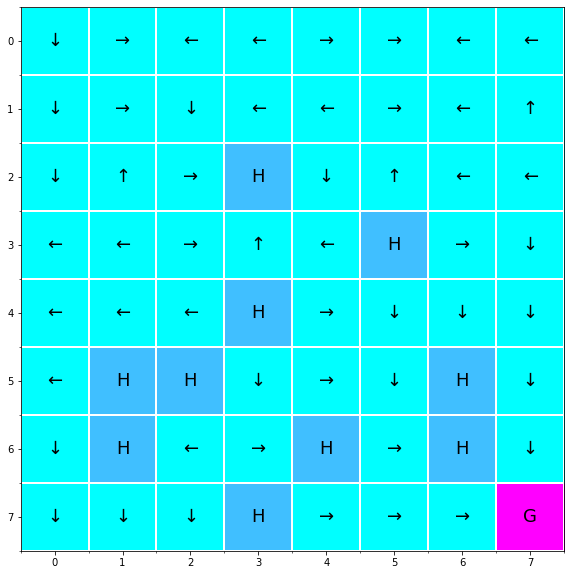

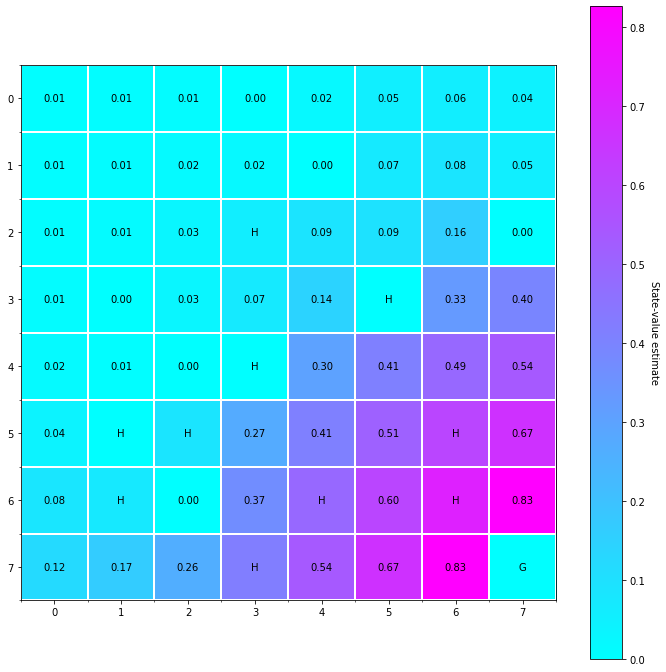

(1, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 3, 1, 3, 2, 1, 1, 3, 0, 0, 0, 0, 2, 3, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0)
(0.005326179144144566, 0.00790967993660409, 0.009925034167129067, 0.0, 0.020779722985473075, 0.051660065902674884, 0.056581399357032866, 0.04497065609396183, 0.007372747060664127, 0.011132149102053826, 0.018492954635142174, 0.021691105366840983, 0.0, 0.0684480550554147, 0.08469790685955356, 0.05367247440464147, 0.008855490229776674, 0.014442756829935297, 0.030344985671629892, 0.05646216439192965, 0.08817733662768663, 0.09491906598568868, 0.15578086949555756, 0.0, 0.009938468007660597, 0.0, 0.029740686537483945, 0.06846424250578313, 0.14170350497210427, 0.0, 0.32719816322240775, 0.39652754063638024, 0.018637693861740575, 0.00501652729771959, 0.0, 0.0, 0.3011898850303939, 0.4109431236777059, 0.49029724822451626, 0.5371161224599889, 0.03945682407986929, 0.0, 0.08493760602731107, 0.27139772768607406,

In [5]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name=None, desc=None)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)
vi = mdp.ValueIteration(p, r, 0.96, max_iter=10000)
vi.run()
visualize_policy(vi.policy, sz, opt)
visualize_value(vi.V, sz, opt)
print(vi.policy)
print(vi.V)

In [6]:
# Error is defined at line 1180 of:
# https://github.com/hiive/hiivemdptoolbox/blob/master/hiive/mdptoolbox/mdp.py
# It's the change in Q, AKA dQ
def valueIterateGraph(p, r, value_iterate=True):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = list(np.arange(0.5,1,0.04))
    print(gammas)
    for gamma in gammas:
        if value_iterate:
            vi = mdp.ValueIteration(p, r, gamma)
        else:
            vi = mdp.PolicyIteration(p, r, gamma, max_iter=50)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

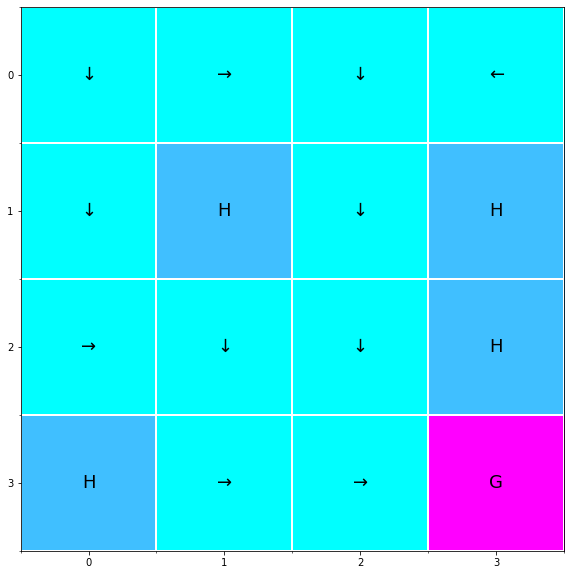

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
0.27303099632263184


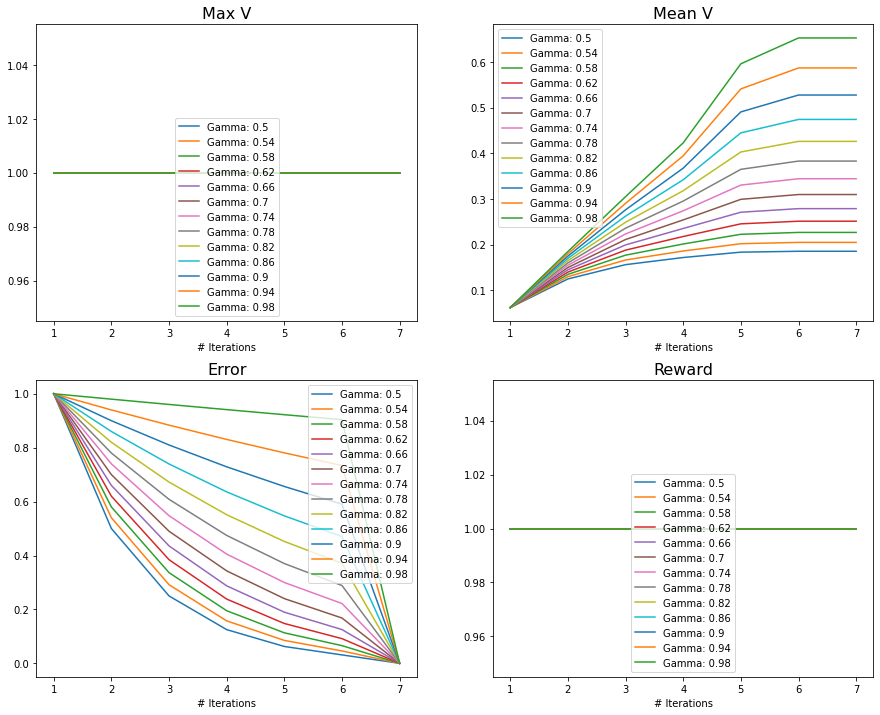

In [7]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False)
r, p = getRewardProb(env,4)
vi = mdp.ValueIteration(p, r, 0.96, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (4,4), "4x4")
valueIterateGraph(p, r)
print(time()-tic)

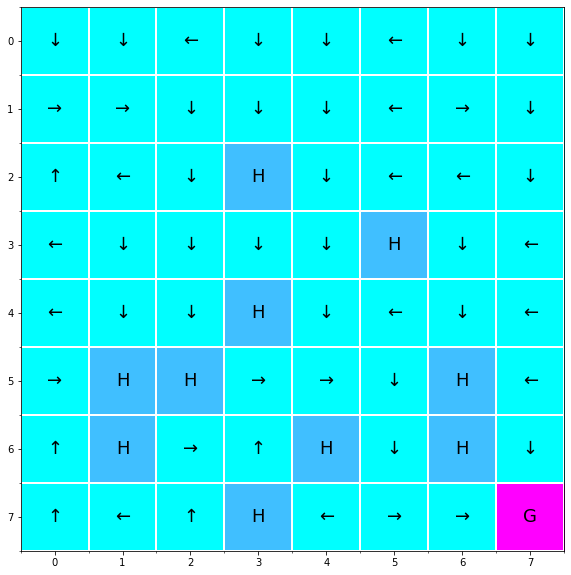

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
0.42639803886413574


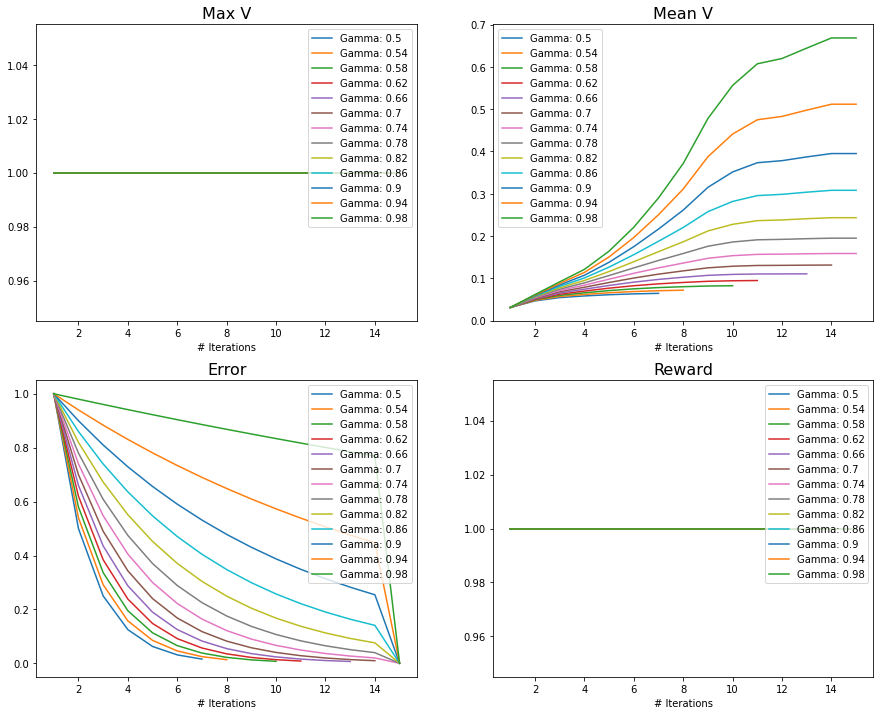

In [22]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False, map_name=None, desc=None)
r, p = getRewardProb(env, 8)
vi = mdp.ValueIteration(p, r, 0.999, max_iter=10000)
vi.run()
visualize_policy(vi.policy, (8,8), "8x8")
valueIterateGraph(p, r)
print(time()-tic)

In [9]:
def runEpisodes(episodes, gamma, sz, max_iter=5000):
    total_rewards = []
    total_successes = 0
    for episode in tqdm(range(episodes)):
        if sz == 8:
            env = gym.make("FrozenLake-v1", is_slippery=True, map_name="8x8")
            env.reset()
            r, p = getRewardProb(env, 8)
        elif sz == 4:
            env = gym.make("FrozenLake-v1", is_slippery=True, map_name="4x4")
            env.reset()
            r, p = getRewardProb(env, 4)
        vi = mdp.ValueIteration(p, r, gamma, max_iter=max_iter)
        vi.run()
        done = False
        state = 0
        policy = vi.policy
        total_reward = 0
        t = 0
        while not (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G') and t<3000:
            action = policy[state]
            state, reward, done, info = env.step(action)
            total_reward += reward
            if (env.desc[state//sz][state%sz]==b'H' or env.desc[state//sz][state%sz]==b'G'):
                if reward == 1:
                    total_successes += 1
                break
            t += 1
        total_rewards.append(total_reward)
    return total_successes

In [10]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates4 = []
for gamma in tqdm(gammas):
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=4)
    success_rates4.append(np.round(total_successes/episodes, 3))
print(success_rates4)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 341.90it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 372.51it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 402.69it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 385.44it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 401.88it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 423.55it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 367.13it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 379.71it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 401.51it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 377.89it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 355.59it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 379.65it/s]

100%|███████████

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 383.77it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 378.96it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 338.77it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 378.47it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 390.23it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 338.71it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 350.98it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 347.62it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 319.70it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 345.75it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 302.42it/s]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 338.82it/s]

100%|███████████

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.2, 0.2, 0.3, 0.1, 0.1, 0.2, 0.1, 0.2, 0.2, 0.2, 0.0, 0.3, 0.4, 0.1, 0.4, 0.1, 0.3, 0.2, 0.2, 0.2, 0.1, 0.4, 0.6, 0.3, 0.3, 0.1, 0.2, 0.3, 0.2, 0.2, 0.3, 0.2, 0.3, 0.2, 0.4, 0.6, 0.3, 0.5, 0.6, 0.6, 0.1, 0.4, 0.5, 0.3, 0.3, 0.7, 0.6, 0.5, 0.4, 0.4, 0.5, 0.7, 0.5, 0.4, 0.6, 1.0, 0.8, 0.7, 0.9, 0.6, 0.7]


In [11]:
gammas = [el/100 for el in list(range(1, 100, 1))]
success_rates8 = []
for gamma in gammas:
    episodes = 10
    total_successes = runEpisodes(episodes = episodes, gamma=gamma, sz=8)
    success_rates8.append(np.round(total_successes/episodes, 3))
print(success_rates8)

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 131.14it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.5, 0.5, 0.7, 0.6, 0.7, 0.8]


Text(0.5, 0, 'Gamma')

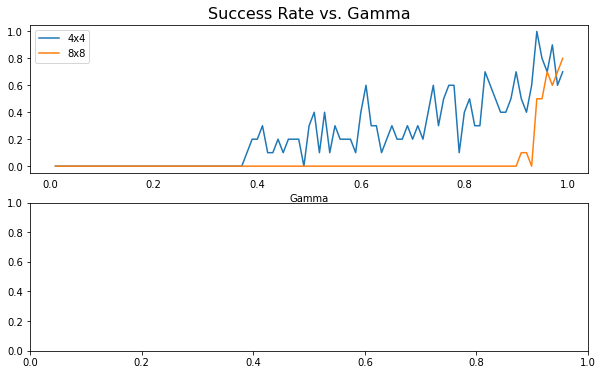

In [12]:
f, ax = plt.subplots(2, figsize=(10,6))
ax[0].set_title("Success Rate vs. Gamma", fontsize=16)
ax[0].plot(gammas, success_rates4, label="4x4")
ax[0].tick_params(bottom=False)
ax[0].plot(gammas, success_rates8, label="8x8")
ax[0].legend()
ax[0].set_xlabel("Gamma")

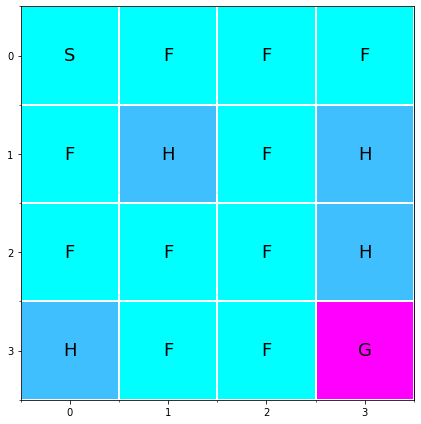

0.0026471614837646484
0.0012331008911132812


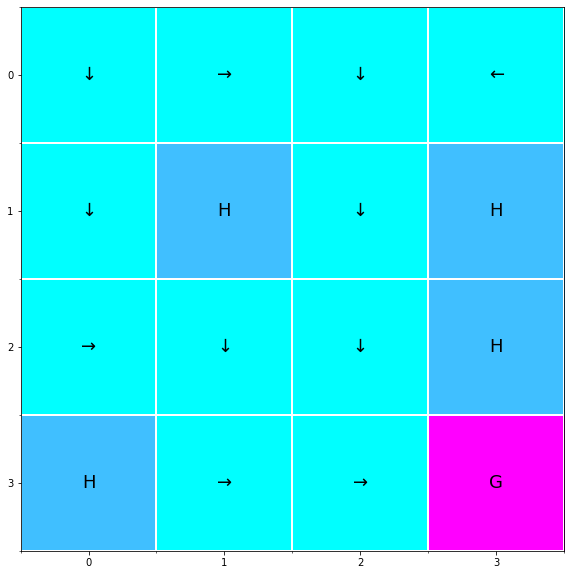

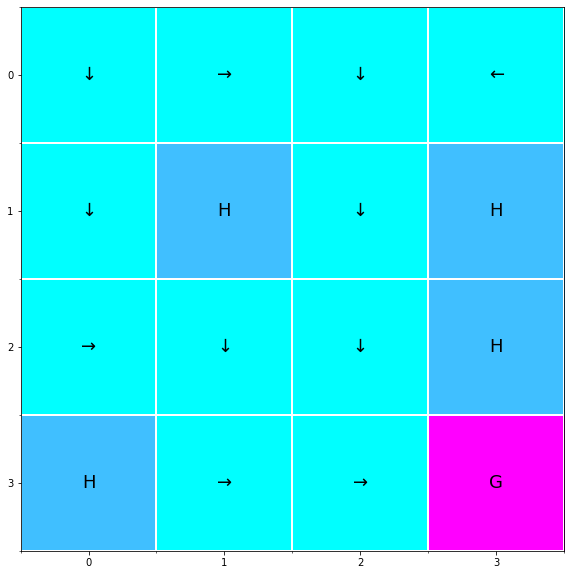

In [13]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1",is_slippery=False)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)

tic = time()
vi1 = mdp.PolicyIteration(p, r, 0.96, max_iter=10000)
vi1.run()
print(time()-tic)

tic = time()
vi2 = mdp.ValueIteration(p, r, 0.96, max_iter=10000)
vi2.run()
print(time()-tic)

visualize_policy(vi1.policy, sz, opt)
visualize_policy(vi2.policy, sz, opt)

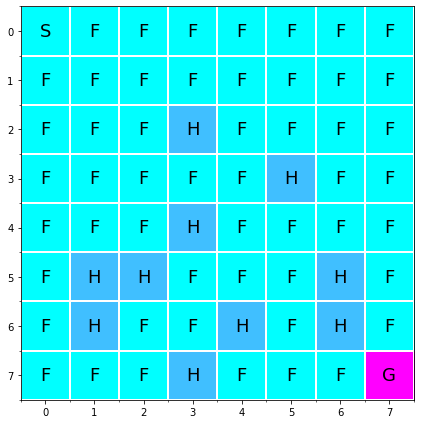

0.0060079097747802734
0.0018930435180664062


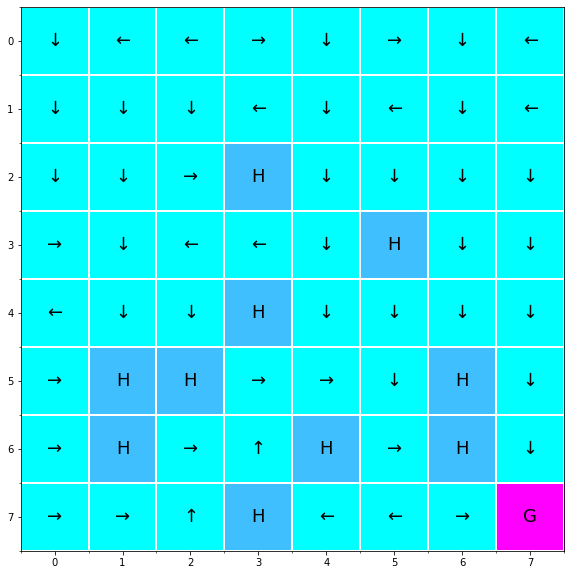

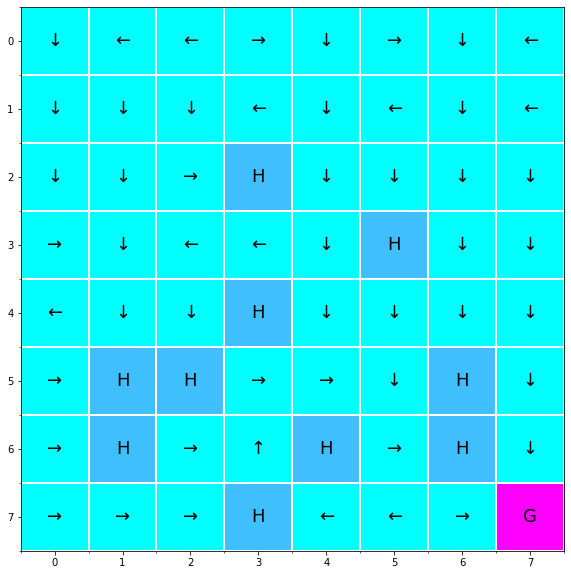

In [16]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", is_slippery=False, map_name=None, desc=None)
env.reset()
visualize_env(env, opt)
r, p = getRewardProb(env, s)

tic = time()
vi1 = mdp.PolicyIteration(p, r, 0.999, max_iter=100000)
vi1.run()
print(time()-tic)

tic = time()
vi2 = mdp.ValueIteration(p, r, 0.999, max_iter=100000)
vi2.run()
print(time()-tic)

visualize_policy(vi1.policy, sz, opt)
visualize_policy(vi2.policy, sz, opt)

In [43]:
print("Policies match {}%".format(100*(np.array(vi1.policy) == np.array(vi2.policy)).sum()/np.array(vi1.policy).shape[0]))

Policies match 96.875%


[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]


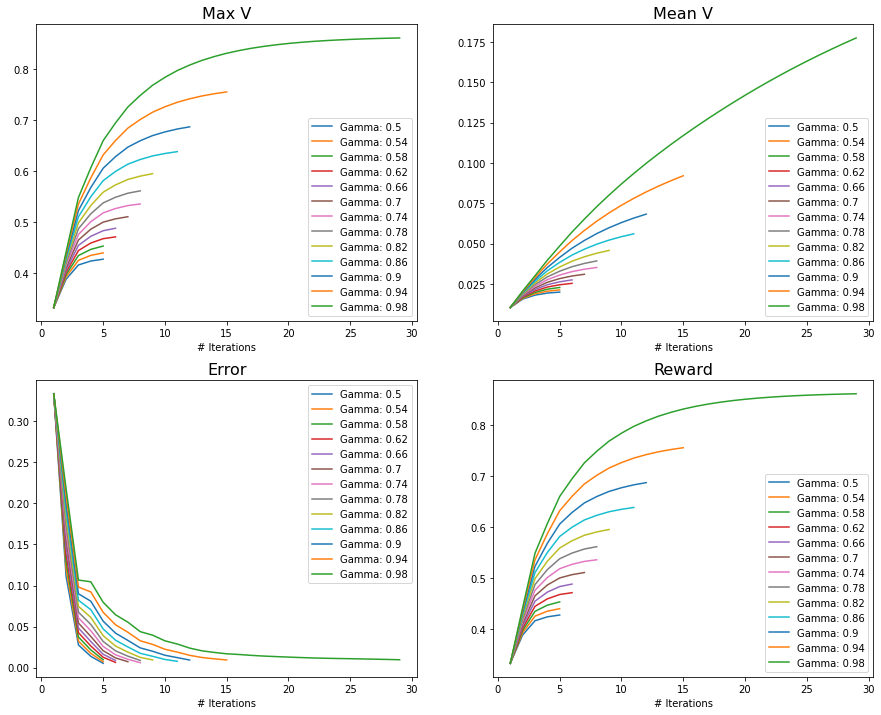

In [20]:
env = gym.make("FrozenLake-v1", is_slippery=True, map_name=None, desc=None)
r, p = getRewardProb(env,8)
valueIterateGraph(p, r)

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
0.14722204208374023


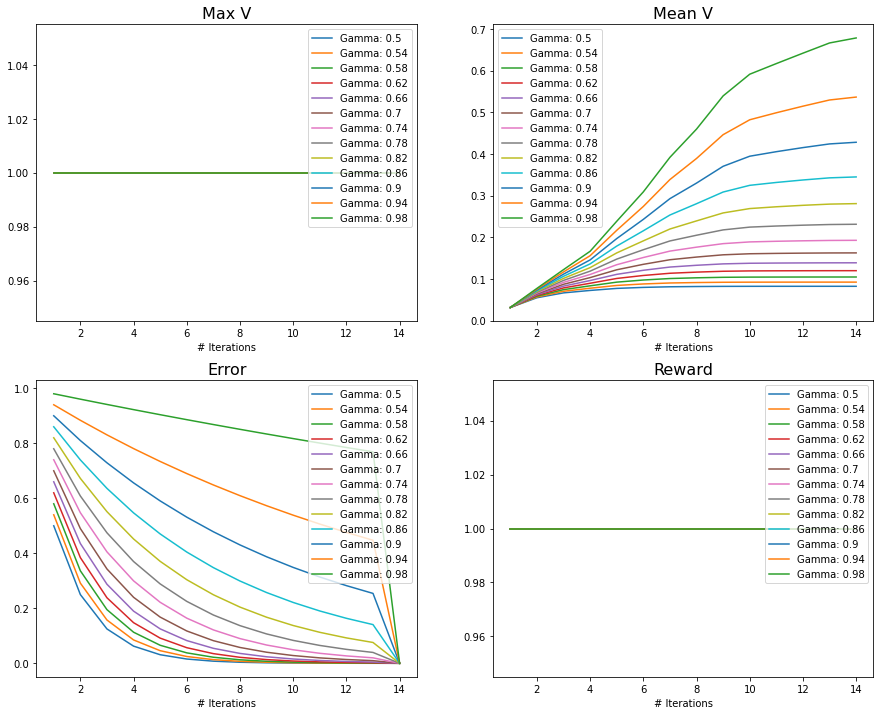

In [36]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False, map_name=None, desc=None)
r, p = getRewardProb(env,8)
valueIterateGraph(p, r, False)
print(time()-tic)

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]


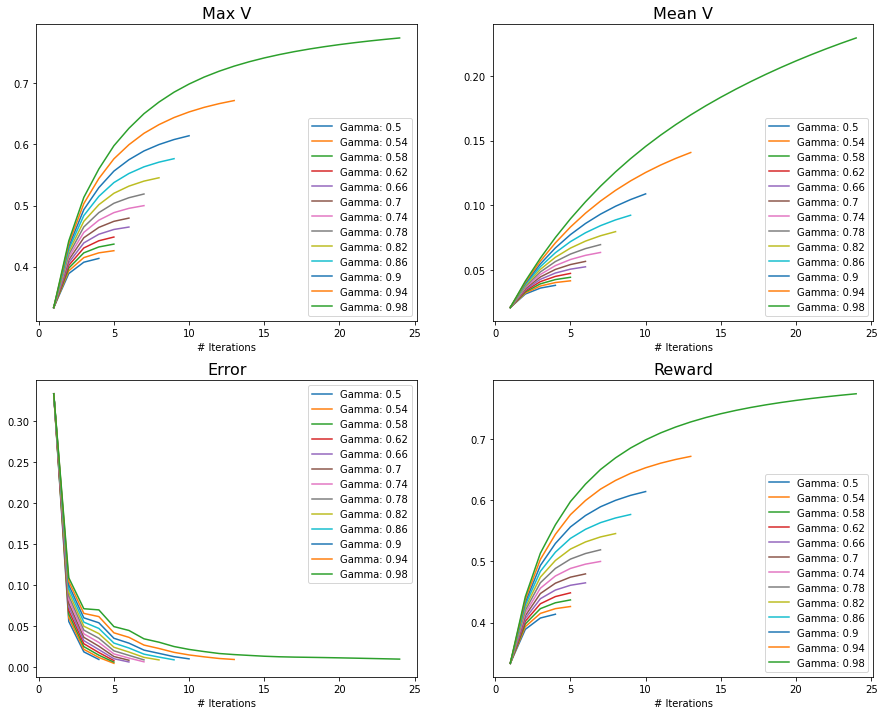

In [21]:
env = gym.make("FrozenLake-v1", is_slippery=True)
r, p = getRewardProb(env,4)
valueIterateGraph(p, r)

[0.5, 0.54, 0.5800000000000001, 0.6200000000000001, 0.6600000000000001, 0.7000000000000002, 0.7400000000000002, 0.7800000000000002, 0.8200000000000003, 0.8600000000000003, 0.9000000000000004, 0.9400000000000004, 0.9800000000000004]
0.11110091209411621


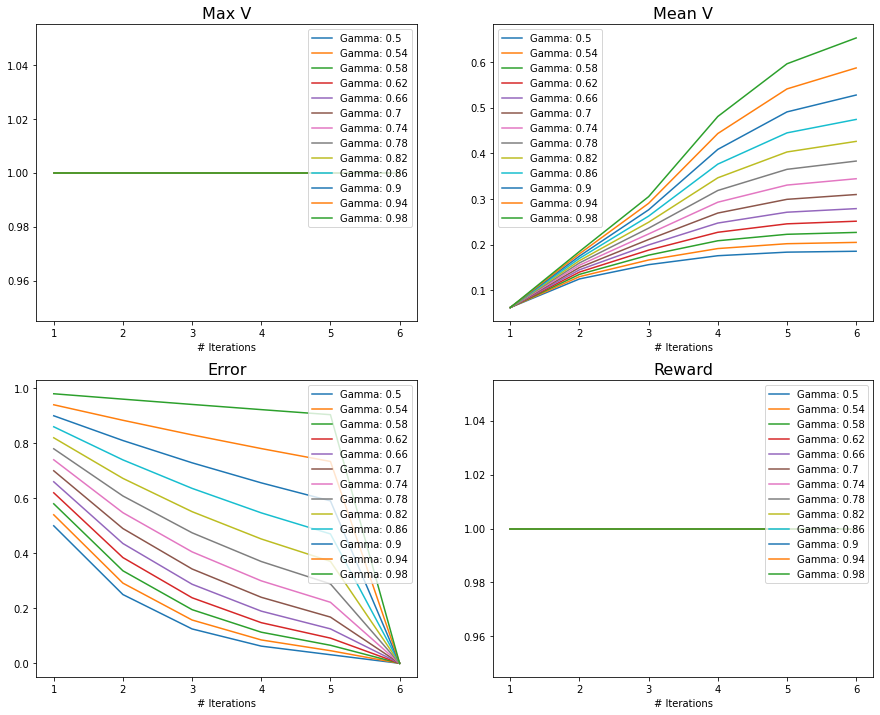

In [22]:
tic = time()
env = gym.make("FrozenLake-v1", is_slippery=False)
r, p = getRewardProb(env,4)
valueIterateGraph(p, r, False)
print(time()-tic)

34.68236231803894


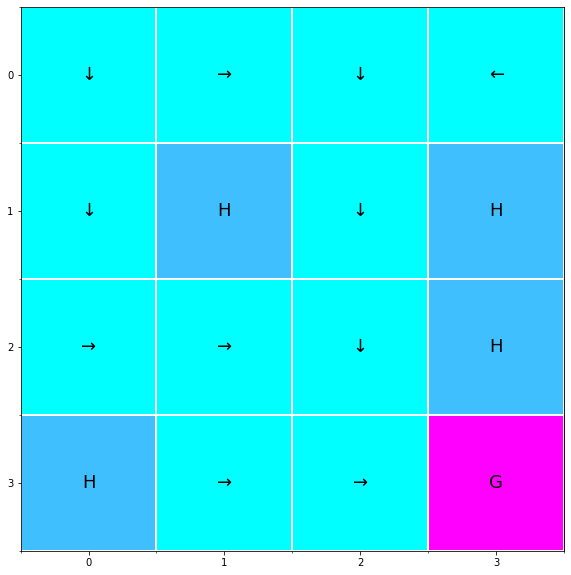

In [15]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.96, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.9999, n_iter=1000000)
vi2.run()
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)

336.2714159488678


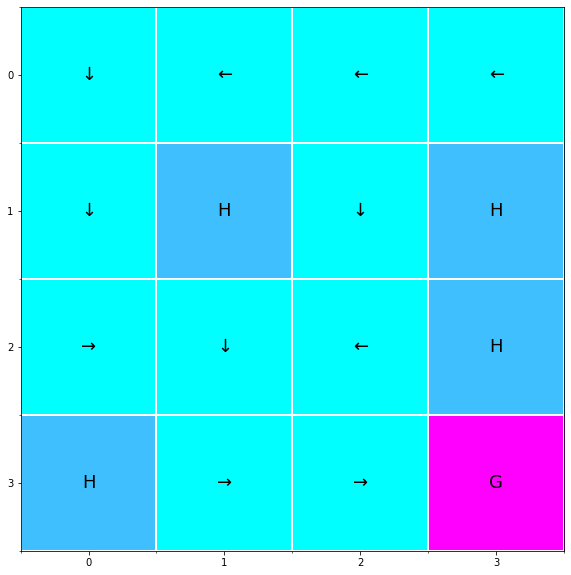

In [16]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.96, alpha=0.1, alpha_decay=0.99999, epsilon=.5, epsilon_decay=0.9999, n_iter=10000000)
vi2.run()
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)

42.26446580886841


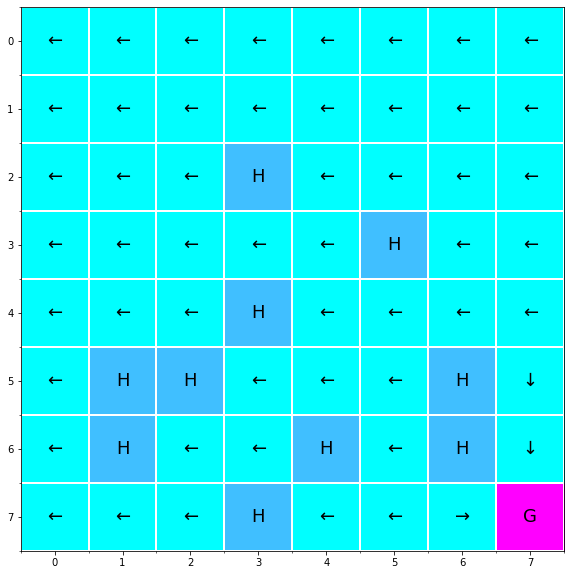

In [18]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.9999, n_iter=1000000)
vi2.run()
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)

489.92080092430115


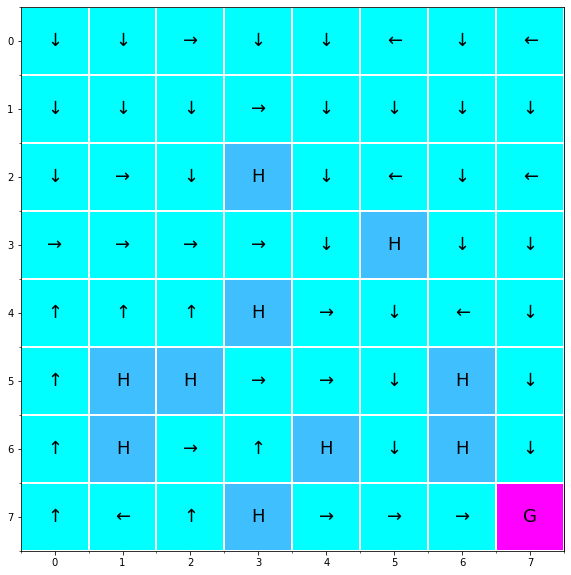

In [19]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)

tic = time()
# vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.999, epsilon=1, epsilon_decay=0.99, n_iter=100000)
vi2 = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99999, epsilon=.2, epsilon_decay=0.9999, n_iter=10000000)
vi2.run()
print(time()-tic)

visualize_policy(vi2.policy, sz, opt)

In [20]:
def QLearnGraphGammas(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    gammas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]
    for gamma in gammas:
        vi = mdp.QLearning(p, r, gamma=gamma, alpha=0.1, alpha_decay=0.99999, epsilon=1, epsilon_decay=0.9999, n_iter=10000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()
    
def QLearnGraphEpsilons(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    rewards = []
    iterations = []
    epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    for epsilon in epsilons:
        vi = mdp.QLearning(p, r, gamma=0.9, alpha=0.1, alpha_decay=0.99999, epsilon=epsilon, epsilon_decay=0.9999, n_iter=10000000)
        vi.run()
        vi.run_stats
        iterations.append(list(range(1,len(vi.run_stats)+1)))
        max_vs.append([el['Max V'] for el in vi.run_stats])
        mean_vs.append([el['Mean V'] for el in vi.run_stats])
        errors.append([el['Error'] for el in vi.run_stats])
        rewards.append([el['Reward'] for el in vi.run_stats])

    f, ax = plt.subplots(2,2, figsize=(15,12))
    ax[0][0].set_title("Max V", fontsize=16)
    for i in range(len(max_vs)):
        ax[0][0].plot(iterations[i], max_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][0].legend()
    ax[0][0].set_xlabel("# Iterations")

    ax[0][1].set_title("Mean V", fontsize=16)
    for i in range(len(mean_vs)):
        ax[0][1].plot(iterations[i], mean_vs[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[0][1].legend()
    ax[0][1].set_xlabel("# Iterations")

    ax[1][0].set_title("Error", fontsize=16)
    for i in range(len(errors)):
        ax[1][0].plot(iterations[i], errors[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][0].legend()
    ax[1][0].set_xlabel("# Iterations")

    ax[1][1].set_title("Reward", fontsize=16)
    for i in range(len(max_vs)):
        ax[1][1].plot(iterations[i], rewards[i], alpha=1, label="Gamma: {}".format(np.round(gammas[i],3)))
    ax[1][1].legend()
    ax[1][1].set_xlabel("# Iterations")
    plt.plot()

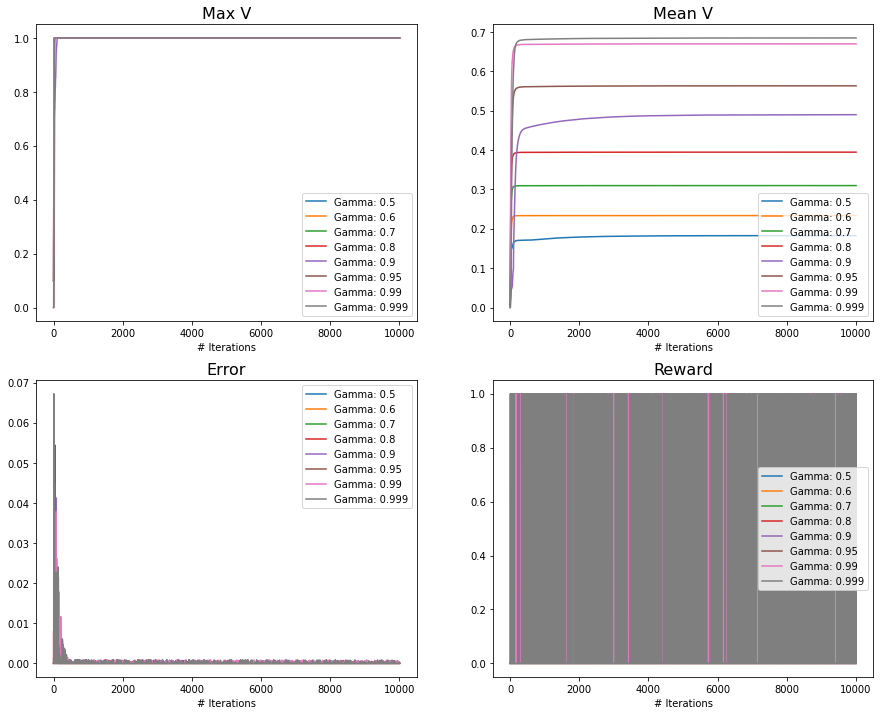

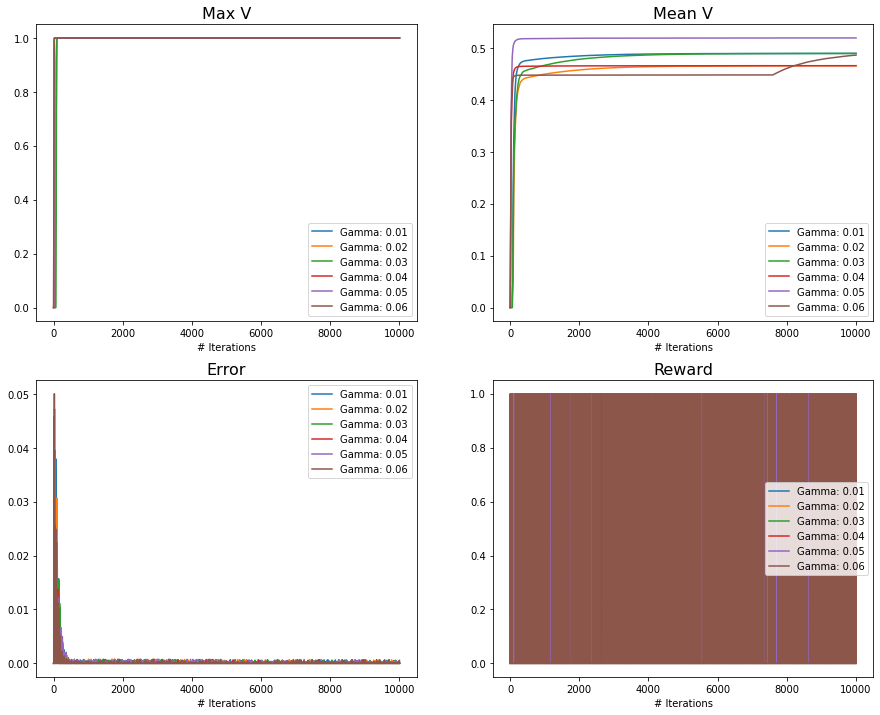

In [22]:
s = 4
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)
QLearnGraphGammas(p, r)
QLearnGraphEpsilons(p, r)

KeyboardInterrupt: 

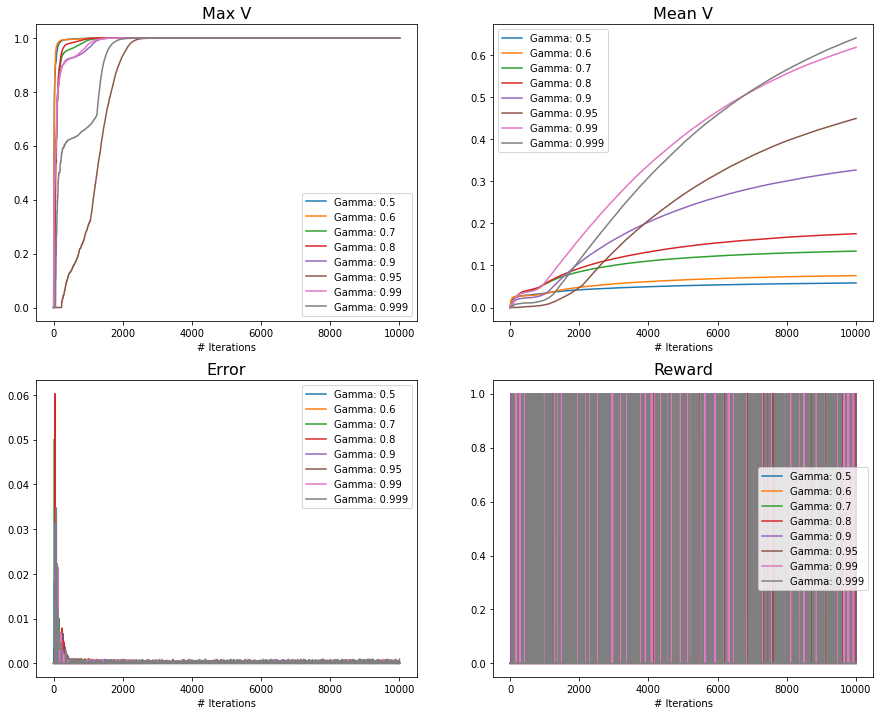

In [26]:
s = 8
opt = "{}x{}".format(s,s)
sz = (s,s)
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env.reset()
r, p = getRewardProb(env, s)
QLearnGraphGammas(p, r)
QLearnGraphEpsilons(p, r)